## Module submission header
### Submission preparation instructions 
_Completion of this header is mandatory, subject to a 2-point deduction to the assignment._ Only add plain text in the designated areas, i.e., replacing the relevant 'NA's. You must fill out all group member Names and Drexel email addresses in the below markdown list, under header __Module submission group__. It is required to fill out descriptive notes pertaining to any tutoring support received in the completion of this submission under the __Additional submission comments__ section at the bottom of the header. If no tutoring support was received, leave NA in place. You may as well list other optional comments pertaining to the submission at bottom. _Any distruption of this header's formatting will make your group liable to the 2-point deduction._

### Module submission group
- Group member 1
    - Name: NA
    - Email: NA
- Group member 2
    - Name: NA
    - Email: NA
- Group member 3
    - Name: NA
    - Email: NA
- Group member 4
    - Name: NA
    - Email: NA

### Additional submission comments
- Tutoring support received: NA
- Other (other): https://medium.com/analytics-vidhya/tokenization-building-a-tokenizer-and-a-sentencizer-c19a00393c19

# DSCI 691: Natural language processing with deep learning <br> Assignment 4: Conversational disentanglement

## Overview 

The purpose of this assigment (69 pts) is to gain firsthand experience constructing a neural network to approach an exciting NLP task: Conversational Disentanglement. Through this assignment, you will apply the techniques introduced in __Chapter 4__ and __Chapter 5__ by constructing a feed-forward neural network in the PyTorch framework.

Recall from __Chapter 2__, the task of conversational disentanglement is one where the goal is to decide which messages in a communication channel reference other messages. Why might such a task be important? Where does something like this crop up? 
- Traditional chat rooms and boards; if there's no comment nesting structure, it can be ambiguous as to who a message is directed to
- Facebook comment sections; with only 1 or 2 levels fo depth, all further comments are collapsed into one level and so the full conversational structure has to be discovered / predicted
- A text group chat with more than 3 people... Was that text directed to you? To everyone? Perhaps there is some ambiguity there as well
- Beyond expliclty _written_ content, a small party in which several conversations are occurring at once might require disentanglement 
- Voice technologies frequently have a wake phrase or word; determining whether that has been said could be a (minor) form of conversational disentanglement!

As language processing technologies evolve and as they become more seamlessly integrated in our lives, their ability to disentangle conversations may become increasingly important. 
This is task is very difficult (see the [original paper](https://www.aclweb.org/anthology/P19-1374.pdf) and observe their performance).

The original paper explores a broad cross-section of structured features, linguistic and other, to construct several models. Here, our task will be to see what we can achieve with simplistic, feed-forward dense neural networks and just the information we can extract from the raw text.

**Note**: In `05-utilities.py`, you'll find our help function `to_gpu()`. If you use Google Collab, you can acess a **limited** amount of time on a GPU for free. **Please know that this is limited and Google will cut you off if you over-use it!** That said, this is a great opportunity to gain some practice with better hardware and training neural networks on the GPU. If you do elect to go this route, please **be careful!** You need to be aware of what device your tensors are on and if you need to do CPU based computations (e.g., scoring predictions), you need to make sure you move things to the CPU through a `.cpu()` call prior to that type of calculation.  __Chapter 5__ should exhibit this behavior, so re-reference that material if this is the path you elect to take.

In this Assignment, we'll be working with the *irc_dataset* discussed in __Chapter 2__.

In [1]:
pip install torch

Note: you may need to restart the kernel to use updated packages.


In [2]:
import json
import time 

from collections import Counter
from sklearn.metrics import classification_report

import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

## Data and Utilities 

Before diving into implementation, it would be good to refresh ourselves with the _irc_dataset_:

In [3]:
pip install datasets

Note: you may need to restart the kernel to use updated packages.


In [4]:
import datasets

ds = datasets.load_dataset('irc_disentangle')
ds

No config specified, defaulting to: irc_disentangle/ubuntu
Reusing dataset irc_disentangle (/Users/dustin.ellis/.cache/huggingface/datasets/irc_disentangle/ubuntu/1.0.0/d58a1b6fbbeeaf735c24246805fbdc44773bd18b765a0711ef19fe7d8e5b2b8c)


DatasetDict({
    train: Dataset({
        features: ['id', 'raw', 'ascii', 'tokenized', 'date', 'connections'],
        num_rows: 220616
    })
    test: Dataset({
        features: ['id', 'raw', 'ascii', 'tokenized', 'date', 'connections'],
        num_rows: 15010
    })
    validation: Dataset({
        features: ['id', 'raw', 'ascii', 'tokenized', 'date', 'connections'],
        num_rows: 12510
    })
})

In [5]:
ds['train'][1050], ds['train'][1055]

({'ascii': "[03:57] <Xophe> (also, I'm guessing that this isn't a good place to report minor but annoying bugs... what is?)",
  'connections': [1048, 1054, 1055, 1072, 1073],
  'date': '2004-12-25',
  'id': 1050,
  'raw': "[03:57] <Xophe> (also, I'm guessing that this isn't a good place to report minor but annoying bugs... what is?)",
  'tokenized': "<s> ( also , i 'm guessing that this is n't a good place to report minor but annoying bugs ... what is ?) </s>"},
 {'ascii': '[03:59] <superted> Xophe: allthough the bug might be minor, it can bring down the user experience',
  'connections': [1050, 1059, 1060],
  'date': '2004-12-25',
  'id': 1055,
  'raw': '[03:59] <superted> Xophe: allthough the bug might be minor, it can bring down the user experience',
  'tokenized': '<s> <user> : allthough the bug might be minor , it can bring down the user experience </s>'})

The essential component we must predict is within the `'connections'` field, where we are required to identify which other messages (by index) are referred to by a given post.
However, as we saw in lecture, this task is ripe with metadata that we can attempt to exploit to simplify this task. 
Specifically:
- Timestamps (and dates)
- Usernames

Together, these two pieces of information allowed us to trim down the combintorial space of all possible pairs of posts.
This was an essential pre-processing heuristic that has allowed us to transform our task down to one of binary classification between pairs of posts.

The sample we'll use is slightly different than what was discussed in __Chapter2__. 
Instead of using a time horizon, the sample constructed
always considers the previous 20 posts 
and determines which (if any) are positive connections.

It is also important to emphasize this reduction will inevitably create an upper limit on any model's final performance, but as we saw in the lecture notes, this should be okay (the upper recall limit on this sample is around 93%).
This dataset has a class imbalance of around 50 negative examples for every positive example, so the task is still very imbalanced and very difficult.

Our assignment will begin with re-loading this data in JSON form and preparing a model that can take two post pairs and output a probabilistic prediction $p \in [0, 1]$ as to whether or not those two posts are connected (e.g., one is replying to the other).

In [6]:
thread = json.load(open('./data/thread.json'))
connections = json.load(open('./data/connections-scrollback.json'))

In [7]:
thread['train']['0'], connections['positive']['train'][0], connections['negative']['train'][0]

({'ascii': "[09:14] <crimsun> kleedrac: I'm afraid not. Any version of mplayer except for -k7* should work for your cpu",
  'connections': [],
  'date': '2004-12-25',
  'id': 0,
  'raw': "[09:14] <crimsun> kleedrac: I'm afraid not. Any version of mplayer except for -k7* should work for your cpu",
  'tokenized': "<s> <user> : i 'm afraid not . any version of mplayer except for <unk#a*-> should work for your cpu </s>",
  'time': '09:14',
  'source': 'crimsun',
  'target': 'kleedrac',
  'dateparsed': '2004-12-25 09:14'},
 ['96381', '96382'],
 ['138089', '138107'])

In [8]:
exec(open('./01-utilities.py').read())
exec(open('./05-utilities.py').read())

# This is our random seed that we'll be sure to set 
# anywhere there is randomness...
# This will ensure reproducibility in our experiments 
# and will help control the variance between your results 
# and that of the sanity checks
# Please do not change this!
A4_RAND_SEED = 691

## Experiment

### 1. (6 pts) Construct a Tokenizer Object

Up until this stage, we've handled tokenization and encoding in a fairly ad hoc fashion with a variety of dictionaries and other simple data structures to aid our transformation from raw text to tokens to type indicies. However, it is fairly commonplace to see many of these transformations bundled together in one object sometimes called the **Vocab** object or the **Tokenizer** object (or a **Vocab** object inside of a **Tokenizer** object). For example, if you want to work with HuggingFace's Transformer library, one of the first things you'd need to acquaint yourself with is their [Tokenizer objects](https://huggingface.co/transformers/tokenizer_summary.html)!

Your first task will be to complete the Tokenizer class definition below. Specifically, the Tokenizer will have 4 methods:
* `__init__(self, raw_text, max_vocab=20_000)`: Given a list of raw texts, constructs the associated `self.type_index` and `self.index_lookup`. This function is pre-written for you, but notice that we are computing the frequencies of all types and only retaining the most frequent tokens as determined by `max_vocab`.
* `tokenize(self, text)`: Given raw text, this function should return the list of tokens.
* `encode(self, text, seq_len=32)`: Given raw text, this function should tokenize the text and then convert each token to its type index. `seq_len` determines the max (and min) length of a post.
* `decode(self, indices)`: Given a list of raw indices, this function should convert the indices to string tokens and combine them back into a single string.

Specifically, your task is to:
1. Complete `tokenize()` using our `tokenize()` function from our `01-utilities.py` file. Specifically, `space=False` for this assignment to help reduce our sequence lengths and number of types. You should store your tokens in a variable named `ts` (which the current code returns).
2. Complete the definition of `encode()`. Notice that we need to be able to handle an unknown token and should encode an `<unk>` when we encode a type that is outside of our `self.type_index`. Additionally, you'll need to write code that pads (or truncates) sequences to `seq_len`. In other words: 
  * If the number of tokens > `seq_len`, you should truncate to the first `seq_len` tokens. 
  * If the number of tokens is less than `seq_len`, you should add `<p>` tokens to fill upto the `seq_len`! 
  * This is a **critical** step for being able to batch-process our data. Your encoded data should be stored in a variable named `indicies`, which the function returns. 
4. Complete the definition of `decode()`. Store the full string in a variable `s`.

In [20]:
# A1:Class(6/6)

class Tokenizer:
    
    # Special tokens for our task
    PAD = '<p>'
    UNK = '<unk>'
    
    def __init__(self, raw_text, max_vocab=20_000):
        # Initialize our type index 
        # to contain our task-specific PAD and UNK tokens
        self.type_index = {
            self.PAD: 0,
            self.UNK: 1
        }
        
        # Compute the frequencies of types
        freqs = Counter([t for raw in raw_text for t in self.tokenize(raw)])
        
        # Extract the most common
        top_cnts = freqs.most_common(max_vocab)

        # Add each retained type to our type_index
        for t in top_cnts:
            t = t[0]
            if t not in self.type_index:
                self.type_index[t] = len(self.type_index)
        
        # Create a reverse type_index: a dictionary that maps indices back to types!
        self.index_lookup = {v: k for k, v in self.type_index.items()}
    
    def tokenize(self, text, space = False): #Given raw text, this function should return the list of tokens.
        #--- your code starts here
        self.raw = text
        ts = tokenize(self.raw)
        #--- your code ends here
        return ts
    
    def encode(self, text, seq_len=32): 
        #Given raw text, this function should tokenize the text and then convert each token to its type index. 
        #seq_len determines the max (and min) length of a post.
        
        #--- your code starts here
        ts = tokenize(text.lower())
        indices = []
        for t in ts:
            indices.append(self.type_index.get(t, self.type_index[self.UNK]))
        #If the number of tokens > seq_len, you should truncate to the first seq_len tokens.
        if len(indices) > seq_len:
            indices = indices[:seq_len]
        #If the number of tokens is less than seq_len, you should add <p> tokens to fill upto the seq_len!
        if len(indices) < seq_len:
            for i in range(seq_len - len(indices)):
                indices.append(self.type_index[self.PAD])
        #--- your code ends here
        
        return indices
    
    def decode(self, indices):#Given a list of raw indices, 
        #this function should convert the indices to string tokens and combine them back into a single string.

        #--- your code starts here
        s = ''
        for indice in indices:
            s += self.index_lookup.get(indice, self.UNK) + " " 
        
        #--- your code ends here
        
        return s

For reference, your output should be:

```
[4, 31, 2, 67, 3, 6, 657, 5, 3604, 2, 94, 2587, 48, 7, 105, 223, 41, 858, 993, 28, 16859, 117, 129, 120, 28, 81, 736, 0, 0, 0, 0, 0]
[ 09 : 14 ] < crimsun > kleedrac : i'm afraid not . any version of mplayer except for -k7 * should work for your cpu <p> <p> <p> <p> <p>

[4, 43, 2, 43, 3, 6, 225, 5, 818, 9, 11, 553, 7709, 19, 389, 7686, 11, 11719, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[ 11 : 11 ] < seveas > amaranth , the us peer is probably breaking the law <p> <p> <p> <p> <p> <p> <p> <p> <p> <p> <p> <p> <p> <p>

[575, 610, 23, 1, 1, 21, 1, 9, 41, 87, 366, 7, 7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
test text that <unk> <unk> and <unk> , of all things . . . <p> <p> <p> <p> <p> <p> <p> <p> <p> <p> <p> <p> <p> <p> <p> <p> <p> <p>
```

In [21]:
# A1:SanityCheck
tokenizer = Tokenizer([post['raw'] for pid, post in thread['train'].items()])

enc = tokenizer.encode(thread['train']['0']['raw'])
print(enc)
print(tokenizer.decode(enc))
print()

enc = tokenizer.encode(thread['test']['0']['raw'])
print(enc)
print(tokenizer.decode(enc))
print()

enc = tokenizer.encode('test text that discusses quarks and leptons, of all things...')
print(enc)
print(tokenizer.decode(enc))
print()

[5, 32, 3, 69, 4, 2, 7, 665, 6, 2, 3712, 3, 2, 260, 2, 2647, 2, 50, 8, 2, 110, 2, 238, 2, 43, 2, 943, 2, 1044, 2, 33, 2]
[ 09 : 14 ]   < crimsun >   kleedrac :   i'm   afraid   not .   any   version   of   mplayer   except   for   

[5, 45, 3, 45, 4, 2, 7, 2574, 6, 2, 10766, 10, 2, 11, 2, 593, 2, 12608, 2, 19, 2, 396, 2, 8360, 2, 11, 2, 12481, 0, 0, 0, 0]
[ 11 : 11 ]   < seveas >   amaranth ,   the   us   peer   is   probably   breaking   the   law <p> <p> <p> <p> 

[589, 2, 623, 2, 26, 2, 1, 2, 1, 2, 23, 2, 1, 10, 2, 43, 2, 90, 2, 364, 8, 8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0]
test   text   that   <unk>   <unk>   and   <unk> ,   of   all   things . . . <p> <p> <p> <p> <p> <p> <p> <p> <p> 



### 2. (5 pts) Construct a PyTorch Dataset

For this next question, your task is to complete a PyTorch Dataset implementation for this dataset. 

Recall from __Chapter 5__, a PyTorch dataset is a class that has two key functions:
* `__len__()`: Which returns the integer length of the dataset
* `__getitem__(item)`: Which returns the an instance of the datset, specified by the `item` parameter (an index)

Specifically, our `ConvoData` class will accept the following parameters in its constructor (`__init__`):
* `tokenizer`: An instance of the `Tokenizer` class (which we built in A1)
* `thread`: Our thread JSON
* `connections`: Our connections JSON
* `split`: A string indicating whether this data should contain the `train`, `validation`, or `test` data

You will complete the implementation of the `__init__` function such that our raw posts for our `split` are stored in `self.encoded_posts` and our postiive AND negative connections are stored in `self.connections` in a 3-tuple of the form `(pid1, pid2, 0/1)`. 

Additionally, your task will be to complete:
* `__len__` to return the number of annotated post pairs in this split. 
* `__getitem__` to return a specific instance of the form:

```
{
  'text1': torch.LongTensor([<encoded post_1 sequence here>]),
  'text2': torch.LongTensor([<encoded post_2 sequence here>]),
  'label': 0/1
}
```

In [18]:
# A2:Class(5/5)

class ConvoData(torch.utils.data.Dataset):
    
    def __init__(self, tokenizer, thread, connections, split):
        self.tok = tokenizer

        # Dictionary that should map:
        # post_id --> the raw post text, encoded by our tokenizer
        self.encoded_posts = {}

        # List of the sampled positive/negative connection examples
        # Elements have the form (post_id1, post_id2, 0/1)
        self.connections = []
        for connection in connections['positive'][split]:
            pid1 = str(connection[0])
            pid2 = str(connection[1])
            label = 1
            self.connections.append((pid1,pid2,label))
        for connection in connections['negative'][split]:
            pid1 = str(connection[0])
            pid2 = str(connection[1])
            label = 0
            self.connections.append((pid1,pid2,label))
                      
        #--- your code starts here
        for post_id, post in thread[split].items():
            self.encoded_posts[str(post_id)] = self.tok.encode(post["raw"])
            
        
        #--- your code ends here
    
    def __len__(self):
        #--- your code starts here
        #to return the number of annotated post pairs in this split.
        length = len(self.connections)
        #--- your code ends here
        return length
    
    def __getitem__(self, item):
        #to return a specific instance of the form
        #--- your code starts here
        pid1 = self.connections[item][0]
        pid2 = self.connections[item][1]
        label = self.connections[item][2]
        
        x = {
            'text1': torch.LongTensor(self.encoded_posts[pid1]),
            'text2': torch.LongTensor(self.encoded_posts[pid2]),
            'label': label }
        
        #--- your code ends here

        return x

For reference, your output should be:

```
Split: train
Length of split: 2766993
Item 0: {'text1': tensor([    4,    39,     2,   174,     3,     6,  2207,     5,    10,    44,
          160,  4734,  1088,  3518,    25,    11,  5830,   832,    32,    47,
        18791,    25,    17,   981,     0,     0,     0,     0,     0,     0,
            0,     0]), 'text2': tensor([    4,    39,     2,   174,     3,     6,  2207,     5,    56,  1225,
           56, 16458,    19,   416,   333,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0]), 'label': 1}
--------------------------------------------------
Split: validation
Length of split: 150139
Item 0: {'text1': tensor([   4,   43,    2,   83,    3,    6,  199,    5,    1,    2, 4987,    9,
         108,   92,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0]), 'text2': tensor([    4,    43,     2,    83,     3,     6,   199,     5,     1,     2,
          128,   576,  1010, 16337,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0]), 'label': 1}
--------------------------------------------------
Split: test
Length of split: 191685
Item 0: {'text1': tensor([   4,   78,    2,  133,    3,    6,  552,    5,    1,    2,   46,   20,
          89,   59,   13,   74, 1920,   14,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0]), 'text2': tensor([    4,    78,     2,   177,     3,     6,     1,     5,   552,     2,
           10,    62,   115,    13,   606,   126,   793,   890,    21,  1299,
            7,    16,   296,    56,   167,    60, 14883,     7,     0,     0,
            0,     0]), 'label': 1}
--------------------------------------------------
```

In [19]:
# A2:SanityCheck

splits = ['train', 'validation', 'test']
data = {key: ConvoData(tokenizer, thread, connections, key) for key in splits}

for split in splits:
    print(f'Split: {split}')
    print(f'Length of split: {len(data[split])}')
    print(f'Item 0: {data[split][0]}')
    print('-' * 50)

Split: train
Length of split: 2766993
Item 0: {'text1': tensor([    5,    41,     3,   171,     4,     2,     7,  2256,     6,     2,
           21,     2,    49,     2,   165,     2,  4924,     2,  1131,     2,
        12042,     2,    27,     2,    11,     2, 10683,     2,   908,     2,
           34,     2]), 'text2': tensor([    5,    41,     3,   171,     4,     2,     7,  2256,     6,     2,
           57,     2,  1287,     2,    57,     2, 19279,     2,    19,     2,
          428,     2,   335,     0,     0,     0,     0,     0,     0,     0,
            0,     0]), 'label': 1}
--------------------------------------------------
Split: validation
Length of split: 150139
Item 0: {'text1': tensor([   5,   45,    3,   83,    4,    2,    7,  199,    6,    2,    1,    3,
           2, 5615,   10,    2,  116,    2,   94,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0]), 'text2': tensor([    5,    45,     3,    83,     4,     2,     7,   199,     6

### 3. (4 pts) Prepare Pre-Trained Word Embeddings

A final step before building out our net will be to load a set of pre-trained word vectors into a Torch $|V| \times d$-dim matrix. We'll then be using this matrix within our neural net as the initial embedding layer!

We've done the heavy-lifting for you all already by performing a word vector pre-training stage (using the attached PyTorch GloVe notebook). 
The code below loads these vectors into a dictionary that maps a string type to its associated pre-trained vector (as a `torch.FloatTensor`).

Oftentimes when we deal with pre-trained vectors, we'll have a situation where the pre-trained vectors lack total coverage over our type-space. For example, here, we won't have pre-trained vectors for tokens like `<p>` and `<unk>`! What we do with these un-seen types is up to us but, in general, there are typically two standard approaches:
* Randomly initialize a vector for the unseen types. This is great when we plan to back-propagate _through_ our pre-trained vectors and update them.
* Set them equal to a zero vector. This is a typical approach when we are keeping our pre-trained vectors static. 

For our situation, we'll be keeping our pre-trained vectors fixed, so you should simply initialize unseen vectors to a zero vector!

Your task will be to complete the definition of `prepare_embedding()` which takes as input:
- `tokenizer`: A tokenizer that was constructed through A1.
- `d=256`: The dimensionality of our pre-trained word vectors.

Complete the definition below by:
1. Initializing an`embed` matrix of size `(vocab_size, d)`. (Hint: Is there a PyTorch function we can use here?)
2. Iterate over your entire vocabulary and check if we have a pre-trained vector in `pre_trained`. If so, you should update these rows of our embedding matrix to be the pre-trained vectors!

In [13]:
# A3:Function(4/4)

def prepare_embedding(tokenizer, d=256):
    torch.manual_seed(A4_RAND_SEED)

    # get the vocab size from the tokenizer object
    vocab_size = len(tokenizer.type_index)

    # this targets the number of epochs our pre-trained vectors 
    # have been trained for
    e = 100 if d > 100 else 50
    
    # loading pre-trained vectors from a file
    pre_trained = {}
    for dx in json.load(open(f'./data/glove.irc_dis.gamma.UV.20000v.{d}d.{e}e.json')):

    # each pre-trained vector is stored in this dictionary
    # and indexed by type... 
    # you'll want to use these in your solution.
    pre_trained[dx['type']] = torch.tensor(dx['vec'])
    
    #--- your code starts here
    # from 5.6.1 in notes
    word = tokenizer.decode(tokenizer.type_index)
    word_vectors = pre_trained[dx['type']]
    if word is in model:
        pre_trained[dx['type']] = torch.tensor(dx['vec'])
    else:
        pre_trained[dx['type']] = torch.radn(d)
        
    embed = nn.Embedding.from_pretrained(word_vectors, freeze=False)
    
    #--- your code ends here
    
    return embed

IndentationError: expected an indented block (<ipython-input-13-a0e17b96015f>, line 20)

For reference, your output should be:

```
torch.Size([20002, 256])
tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 5.5330e-02,  6.2050e-02, -5.2781e-01,  ..., -8.6360e-02,
         -1.3103e-01,  3.3915e-03],
        ...,
        [-2.0513e+00,  6.9725e-01, -2.5020e-01,  ..., -1.0655e+00,
         -7.4829e-01, -1.6333e-01],
        [ 9.1595e-01,  1.5415e+00, -5.2368e-01,  ..., -1.4201e+00,
         -1.9484e+00,  2.0252e+00],
        [ 1.5599e-04,  1.4381e-01,  5.2194e-01,  ...,  2.4124e+00,
         -1.5215e+00,  6.3936e-01]])
vector for `the`:
	tensor([-0.0910,  0.7002, -1.0886, -0.0050, -0.8399, -0.8655, -0.8205, -0.0975,
         0.1663,  0.2098, -0.1550,  0.3032,  1.1947,  0.0876, -0.1028,  0.8509,
         0.3207, -0.9995, -0.2678,  0.7552,  0.6390,  1.2122, -0.3684,  0.5813,
        -0.2041, -0.6912, -1.1293, -0.3021,  0.2596,  0.3079,  0.5679, -0.7958,
        -0.4164, -0.5064, -0.2294,  0.2405,  1.1633, -0.3709,  0.7650, -0.8030,
         0.0122, -0.1422,  0.6041,  1.0734,  0.2321,  0.1729,  0.6801,  0.1193,
        -1.1175, -0.4009, -1.3320, -0.2763,  0.2037, -0.5324, -0.0971, -0.3142,
        -0.2396,  0.1987, -0.0235,  0.3011,  0.0988, -0.7174,  1.2308, -0.3195,
         0.0964, -0.0166, -0.8535, -0.7589,  0.3287,  0.9937,  0.8016,  0.2805,
        -0.4909, -0.1287,  0.3736,  0.3364,  0.8932,  0.4876, -0.2766, -0.3640,
         0.2179, -0.2390,  0.2119, -0.3030,  1.0217,  1.0444,  0.5470,  0.3586,
        -0.3584, -0.6174,  0.6934, -0.6052, -0.5884, -0.2945,  0.1169, -0.2979,
        -0.0685, -0.5040,  0.1867,  0.3447,  0.4708, -0.2439,  1.1875, -0.2917,
        -0.1921, -0.0750,  0.0650,  0.6981,  0.5165, -0.1927, -0.3671,  0.2057,
         1.2693,  1.1969,  0.5199,  0.4818,  0.0297, -0.1172,  0.9700, -0.9332,
        -0.1428, -0.3352,  0.0396, -0.4104,  0.4018,  0.1622,  0.2687, -0.1008,
        -0.3142,  0.1844,  0.4746,  1.1243,  0.0201, -0.4580,  0.2855, -0.0864,
        -0.5469, -0.6782,  0.1832,  0.5202, -1.3231,  0.7771, -0.3023,  0.4376,
         0.2205, -0.8284,  0.1404,  0.4204, -0.5316,  0.0499,  0.4126, -0.0607,
         0.4192,  0.9050,  0.2379,  0.5779, -0.5274,  0.0542,  0.6732,  0.3856,
        -1.0804,  0.0189,  0.9192, -0.3898, -0.1322, -0.5356, -0.0569,  0.3646,
        -0.1382,  0.1036, -0.6530, -0.2462,  0.7744, -0.6607,  0.3242,  0.3057,
         1.2024, -0.3707,  0.0821,  1.0900,  0.5451,  0.2304, -0.3726,  0.9965,
        -0.3956,  0.8745,  0.2489, -0.2638,  0.7182,  0.5365, -0.7999,  0.3701,
        -1.1877, -0.7252, -0.2837,  0.1715, -0.8954,  0.4585, -0.5528, -0.8754,
        -0.0083, -1.0111, -0.4509,  0.8309, -0.3232,  0.6305,  0.1970,  0.8007,
        -0.9212, -0.5292,  0.8386,  0.1188,  0.6791,  0.0880,  0.3957, -0.5118,
         0.1173,  0.5930,  1.3257, -0.0593,  0.2846,  0.0891,  1.4265, -0.0245,
        -1.1769,  1.2603,  0.1309, -0.0145, -0.4470, -0.7128, -0.3813,  0.2501,
        -0.9774, -0.1998,  1.1933,  0.8330, -0.2647,  0.4152, -0.5829, -0.2239,
         0.1413, -0.3218, -0.5352,  0.9728,  0.1580, -0.5890, -0.6398, -0.3981,
         0.5045, -0.7699, -0.1118,  1.0034,  0.3314, -0.7870,  0.4526, -0.1126])
vector for `xophe`:
	tensor([ 1.1324,  0.4173, -0.4146,  0.1567, -0.3575, -0.2206, -0.2496, -0.2759,
         0.6857, -0.5423, -0.2127,  1.7711, -1.4535, -2.3756, -0.3175, -0.8497,
        -1.2541, -1.3572,  1.2560, -1.0639, -0.7513,  0.0703,  1.4802, -1.5602,
         1.9193,  0.9983, -0.5161,  1.2262, -0.2240,  1.1793,  1.8929, -1.1358,
        -0.6482,  0.1636, -0.2866, -0.8254, -0.4475, -1.3477, -0.3217, -1.8803,
         0.1699, -1.0760, -1.5206, -0.0466,  0.1418, -1.0264,  0.7537, -0.8741,
         1.7336, -0.4123,  0.9263, -0.5316,  0.0346,  1.2937,  1.0682, -1.1901,
         0.1180,  1.3216,  0.8753,  1.4903, -0.5931, -0.3278,  1.4042, -1.0117,
        -0.8826,  0.9879, -0.3040, -0.9477,  0.6573,  0.4145, -0.3076,  1.5472,
         1.3351,  1.2054, -0.3368, -0.3059,  0.5241, -0.6696, -0.7753, -0.2720,
         0.5460,  0.5958, -1.3903, -1.0661,  1.0803,  2.3237, -0.3914,  0.7134,
         1.7078, -0.4828, -0.6647,  1.5597,  0.0697,  0.7354, -1.3067, -0.4376,
         2.4781,  0.7165, -1.5963, -0.1804, -1.8537,  1.0520, -1.1056,  2.3299,
         1.6530, -1.8528, -0.4195,  1.3122,  0.5254, -2.5972,  2.2549, -0.9238,
        -0.8085,  0.9737,  1.4187, -1.0748, -0.1766,  0.5124,  0.0411,  1.7265,
         1.7008,  3.2463,  0.0769,  1.9462,  0.8518, -0.4637, -0.9173,  0.1669,
        -0.8773,  0.4614, -0.0379,  1.2138, -0.6566,  1.5367, -0.1889,  1.3965,
         1.1827,  0.1792, -0.3957,  0.5739,  0.2144,  0.1297, -2.4859,  1.2890,
        -1.2701,  1.0734,  1.3713, -1.9133,  1.9308, -0.6111, -1.8737,  0.0242,
        -1.8001,  0.2539, -0.1451, -0.3356,  2.2064,  0.8377,  1.4838,  0.0357,
        -2.3894,  1.0459, -0.7166, -0.5763, -0.7279, -1.5633,  1.2064, -0.2727,
         0.3477, -0.9127, -2.3760, -0.0887,  0.0353, -1.3676, -0.2566, -0.0807,
         1.3730,  0.9258, -1.0639,  1.2183, -1.0348,  0.1381, -0.1843, -0.2132,
         1.0605, -0.6190,  2.6138, -0.0423, -0.7377,  0.2770, -0.3714,  0.3304,
         1.3663, -0.0214,  0.3018, -0.3481,  0.6361, -0.5208, -1.9439, -0.8452,
        -0.2644,  0.3772, -1.5110,  1.0063, -1.3015,  0.6810,  0.0167, -0.0650,
        -2.2719, -0.1928, -1.8421, -1.2011, -0.1584,  0.3337, -0.2185,  0.3329,
         0.3673,  0.2895, -1.1270,  1.8562, -1.4428, -2.0154,  0.7433,  1.2795,
        -0.2491, -1.4859,  1.8752, -2.0063,  0.6946,  1.4802, -1.6602, -1.7357,
         1.3383,  0.2147, -1.2828,  0.3084, -0.9286,  0.6403, -1.2112,  2.3265,
         0.3332, -0.5157,  0.4171,  0.3891, -0.8628,  1.2914,  0.1481,  1.5756,
        -0.1282, -0.0356, -0.6774,  0.0214, -0.0577, -2.0577,  0.8632,  1.2437])
vector for `<unk>`: 
	tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
```

In [ ]:
# A3:SanityCheck

embed_tensor = prepare_embedding(tokenizer)
print(embed_tensor.size())
print(embed_tensor)
print(f'vector for `the`:\n\t{embed_tensor[tokenizer.type_index["the"]]}')
print(f'vector for `xophe`:\n\t{embed_tensor[tokenizer.type_index["xophe"]]}')
print(f'vector for `<unk>`: \n\t{embed_tensor[tokenizer.type_index["<unk>"]]}')

### 4. (5 pts) Construct a Network Architecture 

Your next task will be to implement a feed-forward network architecture in PyTorch, designed for this task. To begin, we'll sketch out our architecture.

Recall from A2 that our dataset will yield two input sequences of token indices, $\vec{t}_1$ and $\vec{t}_2$.
The first operation of our network will convert these indices into a dense, embedded representation using an [Embedding layer](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html). Mathematically: 

$$\vec{t}_i = \left[t_0, t_1, ..., t_{31}\right],\ \vec{t}_i \in \mathbb{Z}^{32}$$

$$E_i \in \mathbb{R}^{s \times d}: E_i = \text{Emb}(\vec{t}_i)$$

where $s=32$ (our sequence length) and $d=256$ (our latent word embedding dimension).

After embedding our indices, we have a 2-dimensional tensor $E_i$. What does $E_i$ represent? 

If you reflect for a moment, each of our $s \times d$ matrices is a 2-dimensional representation of our text. Each row represents a type, each column is a latent dimension. No matter what we do, we need a mechanism for aggregating this word-level information into an overall "sentence" or "post" representation. 

Some simple approaches we could take are:
* Just average the word vectors together
* Take a (fixed) weighted-average of the word vectors (think similarly to TF-IDF weighting)
* Learn a weighting for how to average the word vectors 

In this problem, 
we'll take the last approach. 
Specifically, we will concatenate our two embedding sequences $E_0,E_1$ together using `torch.cat()` 
and then will _unroll_ this matrix representation as a single vector of $(2*s*d)$ dimensions.

$$
E = \text{concat}([E_1;E_2]), E \in \mathbb{R}^{2s \times d}
$$

$$
\vec{e} = \text{flatten}(E), \vec{e} \in \mathbb{R}^{2sd}
$$

With $\vec{e}$ in hand, our next step is to process it with the hallmark of dense neural networks: The [Linear Layer](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html). 

$$
\vec{z}_0 = W_0 \vec{e} + \vec{b}_0
$$

with $W_0 \in \mathbb{R}^{d_0 \times 2sd}$ and $\vec{b}_0 \in \mathbb{R}^{d_0}$. You'll notice $d_0$ is a hyperparameter that we may choose.
For this assignment, we'll call this our network's `hidden_dim` and 
we'll choose $d_0=128$. Make note, however, this is a design choice and one that you could adjust in practice (e.g., through hyperparameter tuning).

Next, we'll use a non-linear activation function:

$$
\vec{h}_0 = f(\vec{z}_0)
$$

Again, our choice for non-linear activation is a hyperparameter. 
To use something beyond the familiar sigmoid activation, 
you should use a Rectified Linear Unit activation
or [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html)
for short. 
It functions similarly to sigmoid, but check out the documentation 
to familiarize yourself with this common activation function!

One thing you'll often see in neural networks are normalization layers. 
These control the degree of overfitting that our network will do as well as can help to keep internal values 
concentrated towards a standard normal distribution.
Specifically, we'll use a type of normalization called [Batch Normalization](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html), 
which can make networks more robust. 
Part of your task here is to check out the documentation about this layer, understand how it works, and apply it.

Using $\text{BN}$ as mathematical short-hand for the operation that BatchNorm1d performs, we have that: 

$$
\vec{g}_0 = \text{BN}_0(\vec{h}_0)
$$

As a final step, let's take our current (normalized) hidden representation $\vec{g}_0$ and feed it through a final, linear prediction layer:

$$
\hat{y} = W_1\vec{g}_0 + b_1
$$

where $W_1 \in \mathbb{R}^{1 \times d_0}$ and $b_2 \in \mathbb{R}$.

Note: We will not be applying sigmoid to the final prediction (although, applying sigmoid would convert this raw $\hat{y}$ into a probabilistic prediction...). This is because (as you'll see below) we'll be using the PyTorch loss function [BCEWithLogitsLoss](https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html) which uses a computational trick to combine the loss with the sigmoid computation for more stable gradients.
As mentioned in __Chapter 5__, this isn't a new or different loss function; this is just the combination of negative log likelihood and cross-entropy loss, specifically oriented towards the situation when we aim to do binary classification.

For some, a visualization of the pipeline may also be helpful:

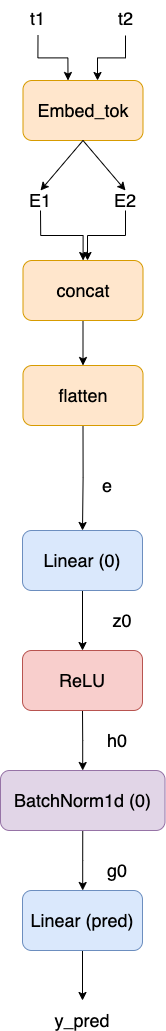

Now that we've sketched out the architecture, your goal is to complete the PyTorch implementation of it. Specifically, you will need to complete both the `__init__` and `forward` functions.

The `__init__` function will receive as input the following parameters:
- `embed_tensor`: The torch.FloatTensor produced in A3 (the previous question).
- `hidden_dim=128`: This is our hyperparameter $d_0$
- `seq_len=32`: This is the length of each token sequence $s$

To complete `__init__`, you should:
1. Construct an embedding layer `self.embed` using [torch.nn.Embedding.from_pretrained](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html#torch.nn.Embedding.from_pretrained). You should be sure to set `freeze=True`. Although back-propagation through our word vectors _could_ give a performance increase, it would also greatly increase training time. (Feel free to play around with `freeze=False` and compare, but just be sure to flip this to `True` before proceeding and/or submitting!).
2. Construct a [Linear layer](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) `self.linear0` that goes from `2 * seq_len * word_dim` features to `hidden_dim` features.
3. Construct a [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html) activation layer and store it in a variable `self.act`
4. Construct a [BatchNorm1D](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html) layer. This takes a parameter `num_features` which you should be able to set to the output size of the previous linear layer (`hidden_dim`). Store this in a variable `self.bn`.
5. Construct a final Linear layer for prediction `self.pred`. This should go `hidden_dim` to 1.

With `__init__` completed, implement `forward` which should take input `t1` and `t2` (our `torch.LongTensor`s of indices) and use the previously initialized layers to compute a prediction `y_pred`. **Do not forget to average your word embeddings and concatenate your two representations prior to applying the next linear layer**.

In [ ]:
# A4:Class(5/5)

class SimpleNet(torch.nn.Module):
    
    def __init__(self, embed_tensor, hidden_dim=128, seq_len=32):
        # call super class constructor
        super(SimpleNet, self).__init__()

        # set the random seed
        torch.manual_seed(A4_RAND_SEED)

        # Extracting the word vector dimension 
        # from our embedding tensor!
        word_dim = embed_tensor.size(1)
    

        #--- your code starts here
        self.embed =  nn.Embedding.from_pretrained(word_vectors, freeze = True )
        self.concat = torch.cat(self.embed)
        self.flatten = torch.flatten(self.concat, start_dim = 1)
        self.linear0 = nn.Linear((2 * seq_len * word_dim), hidden_dim)
        self.act = nn.ReLU()
        self.bn = nn.BatchNorm1d(num_features = hidden_dim, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.pred = nn.Linear(hidden_dim, 1, bias = False)
        #--- your code ends here
        
    def forward(self, t1, t2):
        #--- your code starts here
        self.t1 = self._layer1.forward(t1)
        self.t2 = self._layer2.forward(t2)
        y_pred = self.pred(self.t1, self.t2)
        #--- your code ends here
        
        # your final result should be a tensor 
        # of size (B, 1)
        # where B is the batch size...
        # We should squeeze this to get rid 
        # of the singular dimension in the last axis
        y_pred = y_pred.squeeze(-1)
        
        return y_pred

For reference, your output should produce (Note: test instance output may exhibit substantial random difference):

```
Network architecture:
SimpleNet(
  (embed): Embedding(20002, 256)
  (linear0): Linear(in_features=16384, out_features=128, bias=True)
  (act): ReLU()
  (bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pred): Linear(in_features=128, out_features=1, bias=True)
)

Test instance:
tensor([-0.0377], grad_fn=<SqueezeBackward1>)
```

In [ ]:
# A4:SanityCheck

net = SimpleNet(prepare_embedding(tokenizer))

print('Network architecture:')
print(net)
print()

# To test without training, we need to enter eval mode
# otherwise the BatchNorm1d layer will complain
net.eval()

input_x = data['train'][0]

print('Test instance:')
print(net(input_x['text1'].unsqueeze(0), input_x['text2'].unsqueeze(0)))

### 5. (2 pts) Construct a Loss Function 

For this question, complete the definition of `get_loss_func` which should simply return the loss function needed to train our network. Specifically, this should be the [BCEWithLogitsLoss](https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html#torch.nn.BCEWithLogitsLoss) since we are dealing with a binary class prediction (connected or not connected). 

Also, recall that we have a very unbalanced training set (more than 20 negative connection examples for every positive example). One way we can make our model more sensitive to the minority, positive class is to weight our loss function by supplying a weight as the `pos_weight` parameter in the `BCEWithLogitsLoss` constructor. With that in mind, your job is to complete `get_loss_func` so that it not only returns a `BCEWithLogitsLoss` function, but one that is a _weighted_ `BCEWithLogitsLoss` with `pos_weight=torch.tensor([pos_weight])`. 

Finally, make sure that you're using the `reduction` parameter to specify that we wish to get a total (e.g., a `sum`) instead of the average loss.

Again, the documentation (linked above) is your friend in solving this one :)

In [ ]:
# A5:Function(2/2)

def get_loss_func(pos_weight=1):
    
    #--- your code starts here
    loss_fn = torch.nn.BCEWithLogitsLoss(weight=None, size_average=None, 
                                         reduce=None, reduction='mean', pos_weight=torch.tensor([pos_weight]))
    #--- your code ends here
    
    return loss_fn

For reference, your output should be:
```
BCEWithLogitsLoss()
```

In [ ]:
# A5:SanityCheck

get_loss_func()

### 6. (2 pts) Build an Optimizer

The final piece we need before writing our training loop is an optimizer. 
There are many to choose from, from [SGD](https://pytorch.org/docs/stable/optim.html#torch.optim.Adam) to [Adam](https://pytorch.org/docs/stable/optim.html#torch.optim.Adam). 
For this network, let's use an optimizer called [AdamW](https://pytorch.org/docs/stable/optim.html#torch.optim.AdamW), first proposed as an update to Adam in [Decoupling Weight Decay Regularization](https://arxiv.org/pdf/1711.05101.pdf). 

For this problem, complete the implementation of `get_opt()` which takes as input:
- `module`: a PyTorch module (our network) that we'll be updating the parameters of.
- `lr=0.001`: our desired learning rate
- `wd=0.01`: our desired weight decay parameter

Though AdamW is slightly more complex than, say, Adagrad, the use of it in PyTorch is not that different. Check out the documentation to make sure you're initializing the optimizer with the proper input parameters!

In [ ]:
# A6:Function(2/2)

def get_opt(module, lr=0.001, wd=0.01):
    # --- your code starts here

    # --- your code ends here
    return opt

For reference, your output should be:

```
AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0.01
)
```

In [ ]:
# A6:SanityCheck

get_opt(SimpleNet(embed_tensor))

### 7. (4 pts) Train Function

Your next task is to implement a train function. 

The train function will take as input:
- `net`: A `torch.nn.Module` (e.g., a neural network)
- `data`: Our dictionary of `torch.utils.data.Dataset` splits
- `batch_size`: An integer corresponding to the training batch size 
- `loss_fn`: A loss function
- `opt`: An optimizer 
- `verbose=True`: A flag that, if True, will print average batch loss every `print_every` steps (i.e., every `print_every` batches)
- `test=False`: Another boolean flag that, when True, will cause this loop to exit after 10 batches. This is simply a flag that we'll use in our sanity checks!
- `print_every=1000`: When `verbose=True`, this parameter controls how frequently this function prints a batch loss update.
- `gpu=False`: When True, this flag will push all batch inputs to the GPU first (if it's available). **Don't set this to True if you aren't using a GPU**

Specifically, you should add to this function the following:
1. Zero out the gradients cached in the optimizer
2. Feed the input through `net` to produce a prediction
3. Evaluate this prediction against `y_gold` using `loss_fn` to generate a `loss`
4. Backpropagate the `loss`
5. Update the weights using the optimizer and its `step()` function

In [ ]:
# A7:Function(4/4)

def train_simple(net, data, batch_size, loss_fn, opt, 
                 verbose=True, test=False, print_every=1000,
                 gpu=False):
    # initialize our batch loader
    total_steps = len(data['train']) // batch_size + 1
    loader = torch.utils.data.DataLoader(data['train'], batch_size=batch_size, shuffle=True)
    
    # enable training of our network
    net.train()
    
    start = time.time()
        
    total_loss = 0
    for step, batch in enumerate(loader):
        if gpu:
            # push all batch inputs to gpu
            batch = {k: to_gpu(v) for k, v in batch.items()}

        # prepare gold labels for loss eval
        y_gold = batch['label'].float()
        
        #--- your code starts here

        #--- your code ends here
        
        # accumulate total loss for logging
        # Note that we are:
        #   - Specifically placing this value on the CPU
        #   - Detaching it from its gradient computation
        #   - Calling .item(), which turns single element tensor into a scalar
        total_loss += loss.cpu().detach().item()

        # Print progress if verbose
        if verbose and step % print_every == 0:
            print(f'[{100 * step / total_steps:.3f}%] Step {step}/{total_steps}. Average Loss: {total_loss/(batch_size * (step + 1)):.6f}')

        # Exit early if testing
        if test and step > 10:
            print(f'Total sanity loss: {total_loss:.2f}')
            print(f'Total sanity time: {time.time() - start}')
            break
    
    if verbose and not test: 
        print(f'Total epoch loss: {total_loss:.2f} (Avg. {total_loss / len(data["train"]):.6f})')
        print(f'Total train time: {time.time() - start}')
    
    return total_loss, net

For reference, you should expect output _similar_ to:
```
Total sanity loss: 349.82
```

In [ ]:
# A7:SanityCheck

torch.manual_seed(A4_RAND_SEED)

batch_size = 32
pos_weight = 10

net = SimpleNet(prepare_embedding(tokenizer))
opt = get_opt(net)
loss_fn = get_loss_func(pos_weight)

torch.manual_seed(A4_RAND_SEED)

loss, net = train_simple(net, data, batch_size, loss_fn, opt, test=True)

### 8. (4 pts) Eval Function

Next, let's write a basic eval function. Much like our train, it will take batches of input and feed it through our network. 

Your task will be to complete the loop within the eval function:
1. Feed input into the network to produce `y_preds` (a raw output, non-probablistic)
2. Apply the loss function and store the loss in a variable `loss`!
3. Apply a [sigmoid](https://pytorch.org/docs/stable/generated/torch.sigmoid.html) to transform raw predictions into probabilistic ones
4. Use the `threshold` parameter to construct a binary mask for probabilistic predictions less than this value.
5. Use your binary mask to set predictions above the threshold to 1 (positive prediction) and set those below to 0 (negative prediction).
5. Accumulate the rounded predictions in `preds` and gold labels in `golds`. These will be used to produce an sklearn `classification_report`, which is what this function returns.

Note: Before converting predictions into lists, you may need to call `.detach()` on a tensor if it has any gradient-based information associated with it! If you forget to do so, you may continue to accumulate gradient information (which can exhaust a GPU, if you're using one).

In [ ]:
# A8:Function(4/4)

def eval_simple(net, data, batch_size, loss_fn,
                threshold=0.5,
                split='validation', 
                verbose=True, test=False, print_every=1000, 
                gpu=False):
    # initialize our batch loader
    total_steps = len(data[split]) // batch_size + 1
    loader = torch.utils.data.DataLoader(data[split], batch_size=batch_size, shuffle=True)
    
    # disable training... we're in the eval function!
    net.eval()
    
    start = time.time()
    
    preds = []
    golds = []
    total_loss = 0
    for step, batch in enumerate(loader):
        if gpu:
            # push all batch inputs to gpu
            batch = {k: to_gpu(v) for k, v in batch.items()}

        y_gold = batch['label'].float()
        
        #--- your code starts here

        #--- your code ends here

        # accumulate total loss for logging
        # Note that we are:
        #   - Specifically placing this value on the CPU
        #   - Detaching it from its gradient computation
        #   - Calling .item(), which turns single element tensor into a scalar
        total_loss += loss.cpu().detach().item()

        if verbose and step % print_every == 0:
            print(f'[{100 * step / total_steps:.3f}%] Step {step}/{total_steps}.')

        if test and step > 10:
            break
            
    if verbose: 
        print(f'Total eval time: {time.time() - start}')
    
    return total_loss, classification_report(golds, preds, output_dict=True)

Using our net trained up for ~10 steps in the previous question, apply your evaluation and inspect your classifcation reports. Your performance on the validation set should be around (**Note**: These results are highly susceptible to random noise):

```
{'precision': 0.015151515151515152, 'recall': 0.25, 'f1-score': 0.028571428571428574, 'support': 4}
```

In [ ]:
# A8:SanityCheck

torch.manual_seed(A4_RAND_SEED)

split = 'validation'
batch_size = 32
pos_weight = 10

loss_fn = get_loss_func(pos_weight)

loss, rep = eval_simple(net, data, batch_size, loss_fn, split=split, test=True)
print(rep['1.0'])

### 9. (5 pts) Putting It All Together

We now have everything we need to perform a full training of a network. 
Your task now will be to put together all the pieces in a bundled up `experiment()` function, which takes the following as input:
- `data`: Our dictionary of data splits
- `d=256`: Our word embedding size
- `hidden_dim=128`: The hyperparameter to shape the hidden size within our neural network
- `pos_weight=10`: The weight to be assigned to the positive class through our loss function
- `epochs=10`: The number of epochs to train for
- `batch_size=32`: The training batch size
- `lr=0.001`: The learning rate
- `wd=0.01`: The weight decay rate
- `net_class=SimpleNet`: A neural network constructor. This parameter is what you should use to construct a SimpleNet.
- `train_fn=train_simple`: A function that takes your network and parameters and trains for a single epoch.
- `eval_fn=eval_simple`: A function that evaluates on a split of the data.
- `gpu=False`: A GPU flag that will be propagated to the train and eval function calls. Do not set this to True if you aren't using a GPU. 

Specifically, you should do the following:
- Load a pre-trained embedding tensor using `prepare_embedding()` (A3)
- Initialize a `SimpleNet` (A4) using `net_class`. Store this variable as `net`.
- Initialize a weighted loss function using `pos_weight` (A5, `get_loss_func()`)
- Initialize an optimizer connected to your initialized `SimpleNet` (A6, `get_opt()`)
- Complete the remainder of the training for loop so that for each epoch, we:
  - Run a train iteration and update our net. Store the updated net in the variable `net` and the training loss in `train_loss`.
  - Run an eval iteration over the validation data. Store the loss in `val_loss` and the classification report in `report`.

If you are using a GPU, be sure to push both your `net` and `loss_fn` to that device or else you will get errors!

The remainder of the code will do some checking to see if we've improved our F1-score for the positive class and, if so, will save a model locally. If you're curious to know a bit more, see this awesome [beginner's guide to saving and loading models in PyTorch](https://pytorch.org/tutorials/beginner/saving_loading_models.html).

In [ ]:
# A9:Function(5/5)

def experiment(data, 
               d=256, hidden_dim=128, 
               pos_weight=10, epochs=10, batch_size=32,
               lr=0.001, wd=0.01,
               net_class=SimpleNet, train_fn=train_simple, eval_fn=eval_simple,
               gpu=False):
    torch.manual_seed(A4_RAND_SEED)
    
    # pull our tokenizer out of our Dataset object
    tok = data['train'].tok
    
    #--- your code starts here
    
    #--- your code ends here
    
    best_val = -1 
    best_val_loss = None
    
    # early stopping criteria
    no_imp = 0
    patience = 3  # number of epochs to keep training with no improvement
    
    for e in range(epochs):
        
        print('-' * 20)
        print(f'Begin epoch {e+1}')
        print('-' * 20)

        #--- your code starts here

        #--- your code ends here

        # save model if we do better on F1!
        if report['1.0']['f1-score'] > best_val:
            torch.save(net, f'./data/{type(net) == SimpleNet}_{d}_{hidden_dim}_{pos_weight}_{batch_size}.pt')
            best_val = report['1.0']['f1-score']

            # reset early stopping var
            no_imp = 0
        else:
            # no improvement...
            no_imp += 1
            print(f'No improvement observed for {no_imp} epochs.')

        # saving best validation loss!
        if best_val_loss is None or best_val_loss > val_loss:
            best_val_loss = val_loss

        # Early stopping switch! 
        # If no improvement occurs for several epochs, quit!
        if no_imp >= patience:
            print('Early stopping!')
            break
        
        print()
        print(f'Current train loss: {train_loss:.2f}')
        print(f'Current validation loss: {val_loss:.2f}')
        print(f'Current validation F1: {report["1.0"]["f1-score"]:.4f} (Best: {best_val:.4f})')
        print()

In [ ]:
# A9:SanityCheck

# use this flag to enable/disable GPU if your system has it available!
g = True

experiment(data, gpu=g)

We can also check out our entire classification report for the train and validation splits by re-loading our best saved model:

In [ ]:
# use this flag to enable/disable GPU if your system has it available!
g = True

d = 256
hidden_dim = 128
pos_weight = 10
batch_size = 32

net = torch.load(f'./data/True_{d}_{hidden_dim}_{pos_weight}_{batch_size}.pt')

for s in ['train', 'validation']:
    print('-' * 20)
    print(s)
    print('-' * 20)
    _, score = eval_simple(net, data, batch_size, to_gpu(get_loss_func(pos_weight)), split=s, verbose=False, gpu=g)
    print('P:', score['1.0']['precision'])
    print('R:', score['1.0']['recall'])
    print('F1:', score['1.0']['f1-score'])
    print()

As a sanity check, you should expect that your model is able to attain a positive F1 of ~0.10!

Specifically, you should expect something _similar_ to:

```
--------------------
train
--------------------
P: 0.17169468290928183
R: 0.33547994908911305
F1: 0.22714118509562828

--------------------
validation
--------------------
P: 0.06649976529494601
R: 0.19813519813519814
F1: 0.09957825679475164
```

### Interlude

Thus far, we've built out a reasonable first attempt for this conversational disentanglement task using a very simple neural network and just a set of pre-trained word embeddings. 
As qualified at the start of this assignment, this task is hard and we shouldn't expect to perform it perfectly with a simplistic approach (this is an open research task!). 
That said, we should feel fairly satisfied that thus far, our network appears to be doing "reasonable" things with such a simple architecture and feature set.

Now that we've trained up a relatively simplistic feed-forward neural network, 
it's worth asking ourselves what a better model might look like.

Consider our input into the network. What does it see as input? 
As input, we provide a sequence of types which are immediately embedded as word vectors. 
We then take that 2-dimensional tensor (matrix) and average it along its row dimension to produce a single vector representation of our post-reply pair. 

But wait a minute... that's just CBOW!

If it's using a CBOW-like approach that also means that our network has no preference to word position (it's just a bag-o'-words)!
Could there be more learning power harnassed from factoring in some positional information? 
What about the other metadata we know is associated with the task, like post times?
How could we integrate those into the model?

These next few questions will have you explore the relevance of this other information contained within the raw text
as a learning signal for the task!

### 10. (4 pts) Implement a Position Embedding

Let's start with creating a representation for positional information.
As mentioned in the interlude, our word vectors do not explictly contain any positional information. 
While it's perfectly reasonable to think that our model _could_ learn to infer this information through correlations in word vector dimensions, 
is it reasonable to assume that our model will naturally just "figure it out"?

One way of dealing with positional information in dense models like this one is to use something called a [position encoding](https://kazemnejad.com/blog/transformer_architecture_positional_encoding/) or a position embedding.
This creates an embedding space that encodes information about how far apart two items in a sequence are from one another. 
When we add this information as an additional value (or vector of values) we are explictly telling our model that this information is relevant, 
instead of hoping it just infers it _if it is!_

We could easily set up our model to learn a position embedding, however, 
if we're keeping our word vectors static, why not go with a static position embedding that has the properties we are looking for? 
In fact, in this question we'll implement a standard position embedding space used in modern Transformer models (to help them use the same kind of positional information we want here)!

The position embedding we're going to use encodes positional information using sines and cosines. 
Given a position in the sequence $p$ and an even-latent dimension $k$, we will use a cosine function:

$$
e_{p, 2k} = \cos{\left(\frac{p}{10000^{(2k / d)}}) \right)}
$$

and for odd dimensions, we will use sine:

$$
e_{p, 2k + 1} = \sin{\left(\frac{p}{10000^{(2k / d)}}) \right)}
$$

Notice that the position information factors into this embedding as the numerator the sine argument. 
Additionally, our vector size $d$ and specific vector dimensionality $k$ factor in the exponent in the denominator of the sine argument.
Why 10,000 in the denominator? The intuitive explanation is that this simply needs to be a large number so that when we take it to the $(2k/d)$ power, we'll get noticeably different denominators for our trigonometric functions. 

Your job is to complete the definition below. We've pre-computed the argument values that go into the cosine and sine functions for you (in PyTorch notation), so your job will be to finish the `prepare_position_embeddings()` function to:
1. Update the even-indices of `pe` to be equal to the cosine of the `arg_vals`.
2. Update the odd-indices of `pe` to be equal to the sine of the `arg_vals`.

Hint: PyTorch has helpful `torch.cos` and `torch.sin` functions!

In [ ]:
# A10:Function(4/4)

def prepare_position_embeddings(seq_len=32, pos_dim=32):
    pe = torch.zeros(seq_len, pos_dim)

    position = torch.arange(0, seq_len).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, pos_dim, 2) *
                         -(np.log(10000.0) / pos_dim))
    arg_vals = position * div_term
    
    #--- your code starts here

    #--- your code ends here
    
    return pe

For reference, you should expect your (32, 32)-dimensional position embedding to look like:

```
(torch.Size([32, 32]),
 tensor([[ 1.0000e+00,  0.0000e+00,  1.0000e+00,  ...,  0.0000e+00,
           1.0000e+00,  0.0000e+00],
         [ 5.4030e-01,  8.4147e-01,  8.4601e-01,  ...,  3.1623e-04,
           1.0000e+00,  1.7783e-04],
         [-4.1615e-01,  9.0930e-01,  4.3146e-01,  ...,  6.3246e-04,
           1.0000e+00,  3.5566e-04],
         ...,
         [-7.4806e-01, -6.6363e-01, -8.2537e-01,  ...,  9.1705e-03,
           9.9999e-01,  5.1570e-03],
         [ 1.5425e-01, -9.8803e-01, -3.9725e-01,  ...,  9.4867e-03,
           9.9999e-01,  5.3348e-03],
         [ 9.1474e-01, -4.0404e-01,  1.5322e-01,  ...,  9.8029e-03,
           9.9998e-01,  5.5126e-03]]))
```

In [ ]:
# A10:SanityCheck

pe = prepare_position_embeddings()
pe.size(), pe

Run the following code, which will visualize your position embeddings, and verify that what you've produced looks like the following:

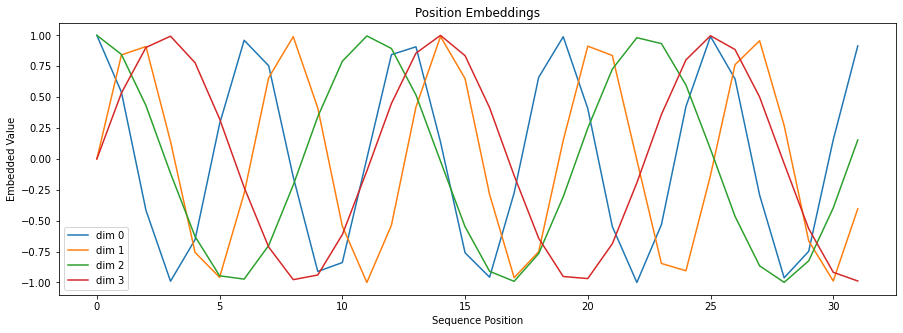

Additionally, this visualization should help you understand **why** this is helpful to a model. 
From the depiction above, each line corrresponds to a dimension in our position embedding which varies across the positions (x-axis).
The different wavelengths of the cosine and sine waves give very precise information 
about how far two items in a sequence are located from one another.
It also does this in a manner that is consistent across training examples. 

Imagine: Even if we only know a few of the 32 input tokens to our network, a model could still intelligently fold some of this information together by using the positional information that it always has access to. In other words, position should (intuitively) give good grounding!

In [ ]:
# A10:SanityCheck

plt.figure(figsize=(15, 5))

pe = prepare_position_embeddings()

for i in range(4):
    xs = list(range(32))
    ys = pe[:, i]
    plt.plot(xs, ys, label=f'dim {i}')
    
    plt.title('Position Embeddings')
    plt.xlabel('Sequence Position')
    plt.ylabel('Embedded Value')
    plt.legend()
    
plt.show()

### 11. (6 pts) Enhance Dataset with Meta Information

Your next task will be to enhance a `torch.utils.data.Dataset` object to include our new desired meta information.

Specifically, we will integrate two pieces of information into our data model:
* The time of messages. Does this affect reply behavior? Is there a learning signal there?
* The positions of each token, which will be used to index into our position embedding. 

Your task, specifically, for this question is to complete the implementation of the `ConvoMetaData` class below. This class should operate identical to your previous class defintion of `ConvoData` (in A2), with the slight difference that the `__getitem__(item)` method will now return the following dictionary form:

```
{
  'text1': torch.LongTensor([<encoded post_1 sequence here>]),
  'text2': torch.LongTensor([<encoded post_2 sequence here>]),
  'time1': time of post1,
  'time2': time of post2,
  'pe1': torch.LongTensor([integer sequence of positions (upto 32)]),
  'pe2': torch.LongTensor([integer sequence of positions (upto 32)]),
  'label': 0/1
}
```

We'll be using these additional properties in an enhanced model (that specifically learns a time embedding!).

In summary, your goal for this question is to:
1. Reproduce your `ConvoData` implementation, but augment it further in the next few steps.
2. Augment `__init__()` to construct the dictionary `self.post_time`. This can be built using a function (provided below) `get_time_index()` which takes the raw text from a post and returns a integer corresponding to $60h + m$, where $h$ is the hour timestamp and $m$ is the minute timestamp. A null timestamp (its not present) will produce an integer of $60 \cdot 24$.
  - This results in a total of $24 \cdot 60 + 1$ unique time values which we will need to be aware of to create an embedding layer in our updated model
3. Augment `__getitem__()` to return the new data form with `pos`, and `time`!

In [ ]:
# Use this function below!
# It should look familiar from Chapter 2!

def get_time_index(txt):
    time_source = re.search("\[(\d\d:\d\d)\] <([^>]+)>", txt)
    if time_source:
        time, _ = time_source.groups()
        hr, mn = time.split(':')
        hr = int(hr); mn = int(mn)
    else:
        hr = 24; mn = 0;

    return hr * 60 + mn

In [ ]:
# A11:Class(6/6)

class ConvoMetaData(torch.utils.data.Dataset):
    
    def __init__(self, tokenizer, thread, connections, split):
        self.tok = tokenizer

        # Dictionary that should map:
        # post_id --> the raw post text, encoded by our tokenizer
        self.encoded_posts = {}

        # Dictionary that should map:
        # post_id --> time_index as determined by get_time_index
        self.post_time = {}

        # List of the sampled positive/negative connection examples
        # Elements have the form (post_id1, post_id2, 0/1)
        self.connections = []

        #--- your code starts here

        #--- your code ends here
    
    def __len__(self):
        #--- your code starts here

        #--- your code ends here
        
        return length
    
    def __getitem__(self, item):
        #--- your code starts here

        #--- your code ends here
        return x

For reference, you should get as output:

```
Split: train
Length of split: 2766993
Item 0: {'text1': tensor([    4,    39,     2,   174,     3,     6,  2207,     5,    10,    44,
          160,  4734,  1088,  3518,    25,    11,  5830,   832,    32,    47,
        18791,    25,    17,   981,     0,     0,     0,     0,     0,     0,
            0,     0]), 'text2': tensor([    4,    39,     2,   174,     3,     6,  2207,     5,    56,  1225,
           56, 16458,    19,   416,   333,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0]), 'time1': 268, 'time2': 268, 'pe1': tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]), 'pe2': tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]), 'label': 1}
--------------------------------------------------
Split: validation
Length of split: 150139
Item 0: {'text1': tensor([   4,   43,    2,   83,    3,    6,  199,    5,    1,    2, 4987,    9,
         108,   92,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0]), 'text2': tensor([    4,    43,     2,    83,     3,     6,   199,     5,     1,     2,
          128,   576,  1010, 16337,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0]), 'time1': 680, 'time2': 680, 'pe1': tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]), 'pe2': tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]), 'label': 1}
--------------------------------------------------
Split: test
Length of split: 191685
Item 0: {'text1': tensor([   4,   78,    2,  133,    3,    6,  552,    5,    1,    2,   46,   20,
          89,   59,   13,   74, 1920,   14,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0]), 'text2': tensor([    4,    78,     2,   177,     3,     6,     1,     5,   552,     2,
           10,    62,   115,    13,   606,   126,   793,   890,    21,  1299,
            7,    16,   296,    56,   167,    60, 14883,     7,     0,     0,
            0,     0]), 'time1': 1164, 'time2': 1166, 'pe1': tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]), 'pe2': tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]), 'label': 1}
--------------------------------------------------
```

In [ ]:
# A11:SanityCheck

splits = ['train', 'validation', 'test']
meta_data = {key: ConvoMetaData(tokenizer, thread, connections, key) for key in splits}

for split in splits:
    print(f'Split: {split}')
    print(f'Length of split: {len(meta_data[split])}')
    print(f'Item 0: {meta_data[split][0]}')
    print('-' * 50)

### 12. (10 pts) Implement Enhanced Model

To implement our enhanced model, first observe that we'll $2*3 = 6$ input variables now:
* Tokens: $\vec{t}_i = \left[t_0, t_1, ..., t_{31}\right],\ \vec{t}_i \in \mathbb{Z}^{s}$
* Post Time: $u_i, u_i \in \mathbb{Z}$
* Positions $\vec{p}_i = \left[0, 1, 2, 3, ..., 31\right],\ \vec{p}_i \in \mathbb{Z}^{s}$

(Recall: $s=32$, our sequence length).

To begin, we'll want to fuse our position embedding and token embedding information into one "mixed" representation. 
To do so, we can first embed both our token and position vectors
and then concatenate that information. Mathematically:
$$E_{\text{tok}, i} \in \mathbb{R}^{s \times d_t}: E_{\text{tok}, i} = \text{Emb}_{\text{tok}}(\vec{t}_i)$$
$$E_{\text{pe}, i} \in \mathbb{R}^{s \times d_p}: E_{\text{pe}, i} = \text{Emb}_{\text{pe}}(\vec{p}_i)$$
$$
E_i \in \mathbb{R}^{s \times (d_p + d_t)}: E_i = \text{concat}([E_{\text{tok}, i};E_{\text{pe}, i}])
$$

If we go ahead and flatten each embedding matrix $E_i$ into a vector $\vec{e}_i$,
we can use a linear layer to project our embeddings into a mixed-representation of a unique message:

$$\vec{z}_{0,i} = W_{\text{mix}} \vec{e}_i + \vec{b}_{\text{mix}},\ W_{\text{mix}} \in \mathbb{R}^{d_{\text{mix}} \times s(d_t + d_p)}, \vec{b}_{\text{mix}} \in \mathbb{R}^{d_{\text{mix}}}$$

$d_{\text{mix}}$ is a free parameter, which we will select to be $d_{\text{mix}}=64$.

After applying this linear layer to both our embedded messages, we'll have two vectors $\vec{z}_{0,1}$ and $\vec{z}_{0,2}$. If we stack them, we can get a familiar $\vec{z}_0$, which we can then apply a non-linear activation and a batch norm operation.

$$\vec{z}_0 = \text{concat}([\vec{z}_{0,1};\vec{z}_{0,2}]),\ \vec{z}_0 \in \mathbb{R}^{2d_{\text{mix}}}$$
$$\vec{h}_0 = f(\vec{z}_0),\ \vec{h}_0 \in \mathbb{R}^{2d_{\text{mix}}}$$
$$\vec{g}_0 = BN_{\text{mix}}(\vec{h}_0),\ \vec{g}_0 \in \mathbb{R}^{2d_{\text{mix}}}$$

As before, let's use a ReLU non-linearity: $f = \text{ReLU}$.

With a latent representation of our two messages, let's go ahead 
and embed our two time inputs,
and concatenate them into a new complex vector:

$$\vec{e}_{\text{time}, i} \in \mathbb{R}^{d_u}: \vec{e}_{\text{time}, i} = \text{Emb}_{\text{time}}(u_i)$$
$$\vec{x}_0 = \text{concat}([\vec{g}_0, \vec{e}_{\text{time}, 1}, \vec{e}_{\text{time}, 2}]),\ \vec{x}_0 \in \mathbb{R}^{2d_{\text{mix}} + 2d_u}$$

Next, we'll fold together this latent message plus time information 
using a familiar computational pipeline:

$$
\vec{z}_1 = W_1 \vec{x}_0 + \vec{b}_1,\ W_1 \in \mathbb{R}^{d_0 \times (2d_{\text{mix}} + 2d_u)}
$$

$$
\vec{h}_1 = f(\vec{z}_1)
$$

$$
\vec{g}_1 = \text{BN}_{1}(\vec{h}_1)
$$

$$
\hat{y} = W_2 \vec{g}_1 + b_2,\ W_2 \in \mathbb{R}^{1 \times d_0}
$$

If you're more visually inclined, see the reference network schematic shown below!

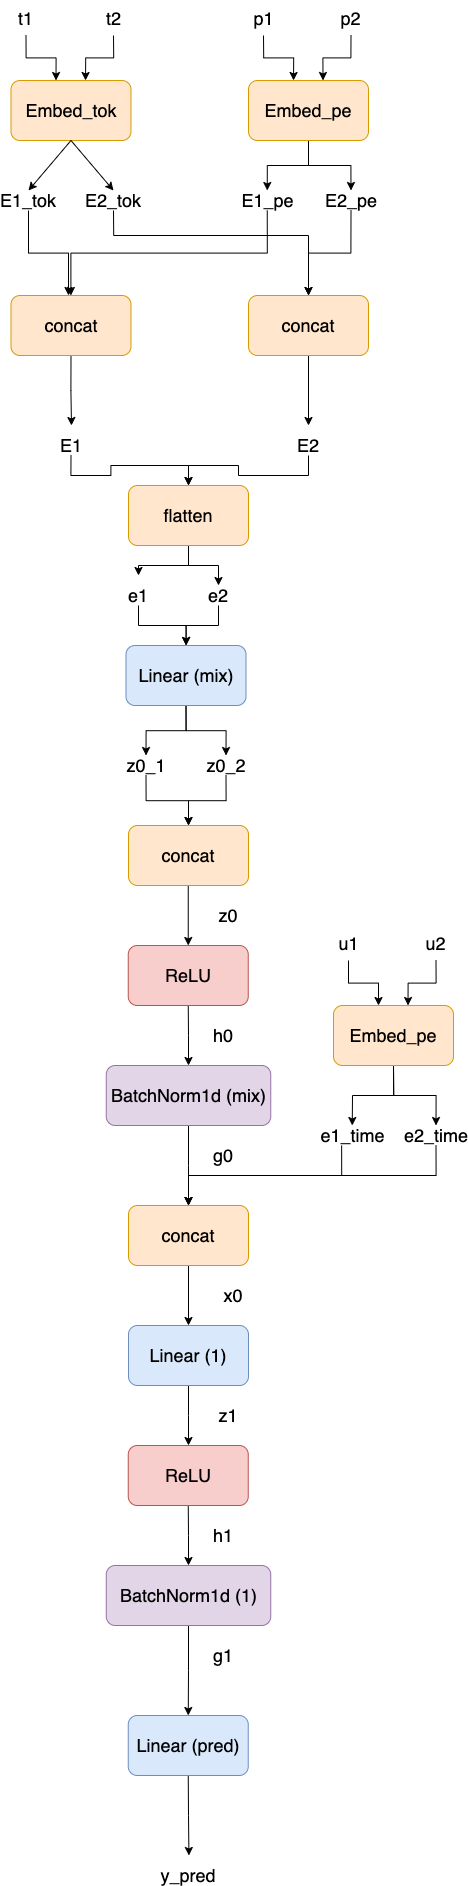

You should notice there are several hyper parameters that are critical for our network's architecture:
* Embedding sizes: $d_t = 256, d_p = 32, d_u = 4$
* Latent representation sizes: $d_\text{mix} = 64$ and $d_0=128$

Furthermore, you should observe that we'll have the following layers:
* Three embeddings:
  * A __frozen__ word embedding
  * A __frozen__ position embedding
  * A trainable time embedding
* Three linear layers: 
  * one for mixing token and position information 
  * one for mixing all message and time information
  * one for final prediction
* An activation layer (which will be used twice). The activation is ReLU.
* Two batch normalization layers:
  * one after mixing token and position information
  * another after mixing messages and time

Your task is to take this mathematical information and finish the implementation of `EnhancedNet` below.

Specifically, you should add to the `__init__()` method:
- A token embedding layer using `torch.nn.Embedding.from_pretrained` and the `embed_tensor` argument. Remember to set `freeze=True`.
- A position embedding layer using `torch.nn.Embedding.from_pretrained` and the `pe` given to you above where your code begins. Again, `freeze=True`!
- A time embedding layer, which will be trainable. There should be $24 * 60 + 1$ input dimensions! Using `time_dim` from the input arguments as the embedding dimension size.
- A linear layer for mixing cross-embedding information that goes from `seq_len * tok_dim` to `mixed_dim`
- A ReLU activation layer 
- A BatchNorm1d layer with `2 * mixed_dim` params 
- Another linear layer going from `2 (mixed_dim + time_dim)` to `hidden_dim`
- Another BatchNorm1d layer with `hidden_dim` params
- A final linear, prediction layer mapping from `hidden_dim` to 1

You'll only need 1 ReLU activation layer, which you can use both times in your implementation of `.forward()`.

To complete the implementation, apply the constructed layers and feed the input parameters through your layers per the mathematical description above!

In [ ]:
# A12:Class(10/10)

class EnhancedNet(torch.nn.Module):
    
    def __init__(self, embed_tensor, mixed_dim=64, hidden_dim=128, seq_len=32, time_dim=8):
        super(EnhancedNet, self).__init__()
        torch.manual_seed(A4_RAND_SEED)
        
        # construct a position embedding matrix
        pe = prepare_position_embeddings()

        p_dim = pe.size(1)  # get the position embed dimension
        word_dim = embed_tensor.size(1)  # get the token embed dimension
        tok_dim = p_dim + word_dim  # tok dim is the full position and type

        #--- your code starts here
  
        #--- your code ends here
        
    def forward(self, t1, t2, u1, u2, p1, p2):
        #--- your code starts here

        #--- your code ends here
        
        # your final result should be a tensor 
        # of size (B, 1)
        # where B is the batch size...
        # We should squeeze this to get rid 
        # of the singular dimension in the last axis
        y_pred = y_pred.squeeze(-1)
        
        return y_pred

For reference, you should something similar to the following as your sanity check:

```
Network architecture: 
EnhancedNet(
  (tok_embed): Embedding(20002, 256)
  (pe_embed): Embedding(32, 32)
  (time_embed): Embedding(1441, 8)
  (linear_mixed): Linear(in_features=9216, out_features=64, bias=True)
  (bn_mixed): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act): ReLU()
  (linearh): Linear(in_features=144, out_features=128, bias=True)
  (bnh): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pred): Linear(in_features=128, out_features=1, bias=True)
)

Test data point: 
tensor([0.1674], grad_fn=<SqueezeBackward1>)
```

In [ ]:
# A12:SanityCheck

net = EnhancedNet(prepare_embedding(tokenizer))
print('Network architecture: ')
print(net)
print()

net.eval()
print('Test data point: ')
x = meta_data['train'][0]
print(net(x['text1'].unsqueeze(0), x['text2'].unsqueeze(0), 
          torch.LongTensor([x['time1']]), torch.LongTensor([x['time2']]),
          x['pe1'].unsqueeze(0), x['pe2'].unsqueeze(0)
          ))
print()

### 13. (5 pts) Enhanced Train Loop

Next, you should adapt the training loop we previously wrote for our `SimpleNet` class. 
Your solution to this question should look _almost identical_ to the previous question, however, here, you need to pay special attention to the four input tensors that we wish to give to the network!

In [ ]:
# A13:Function(5/5)
def train_enhanced(net, data, batch_size, loss_fn, opt, 
                   verbose=True, test=False, print_every=1000,
                   gpu=False):
    # initialize our batch loader
    total_steps = len(data['train']) // batch_size + 1
    loader = torch.utils.data.DataLoader(data['train'], batch_size=batch_size, shuffle=True)
    
    # enable training of our network
    net.train()
    
    start = time.time()
        
    total_loss = 0
    for step, batch in enumerate(loader):
        if gpu:
            # push all batch inputs to gpu
            batch = {k: to_gpu(v) for k, v in batch.items()}

        # prepare gold labels for loss eval
        y_gold = batch['label'].float()
        
        #--- your code starts here

        #--- your code ends here
        
        # accumulate total loss for logging
        total_loss += loss.detach().cpu().item()

        if verbose and step % print_every == 0:
            print(f'[{100 * step / total_steps:.3f}%] Step {step}/{total_steps}. Average Loss: {total_loss / (batch_size * (step + 1)):.6f}')

        if test and step > 10:
            print(f'Total sanity loss: {total_loss:.2f}')
            print(f'Total sanity time: {time.time() - start}')
            break

    
    if verbose and not test: 
        print(f'Total epoch loss: {total_loss:.2f} (Avg. {total_loss / len(data["train"]):.6f})')
        print(f'Total train time: {time.time() - start}')
    
    return total_loss, net

As a sanity check, you should expect an output similar to:
```
Total sanity loss: 350.92
```

In [ ]:
# A13:SanityCheck

torch.manual_seed(A4_RAND_SEED)

batch_size = 32
pos_weight = 10

net = EnhancedNet(prepare_embedding(tokenizer))
opt = get_opt(net)
loss_fn = get_loss_func(pos_weight)

loss, net = train_enhanced(net, meta_data, batch_size, loss_fn, opt, test=True)

### 14. (5 pts) Enhanced Eval Loop

Like with the previous adaptation, adapt the evaluation function you previously wrote. Like before, this adaptation should be _almost identical_ to what you previously wrote. Again, pay mind to the input tensors you supply to your network!

In [ ]:
# A14:Function(5/5)
def eval_enhanced(net, data, batch_size, loss_fn, 
                  threshold=0.5,
                  split='validation', 
                  verbose=True, test=False, print_every=1000,
                  gpu=False):
    # initialize our batch loader
    total_steps = len(data[split]) // batch_size + 1
    loader = torch.utils.data.DataLoader(data[split], batch_size=batch_size, shuffle=True)
    
    # disable training... we're in the eval function!
    net.eval()
    
    start = time.time()
    
    preds = []
    golds = []
    total_loss = 0
    for step, batch in enumerate(loader):
        if gpu:
            # push all batch inputs to gpu
            batch = {k: to_gpu(v) for k, v in batch.items()}

        y_gold = batch['label'].float()
        
        #--- your code starts here

        #--- your code ends here

        total_loss += loss.detach().cpu().item()

        if verbose and step % print_every == 0:
            print(f'[{100 * step / total_steps:.3f}%] Step {step}/{total_steps}.')

        if test and step > 10:
            break
            
    if verbose: 
        print(f'Total eval time: {time.time() - start}')
    
    return total_loss, classification_report(golds, preds, output_dict=True)

For reference, you should expect a sanity check output similar to:
```
{'precision': 0.010416666666666666, 'recall': 1.0, 'f1-score': 0.020618556701030924, 'support': 4}
```

In [ ]:
# A14:SanityCheck
torch.manual_seed(A4_RAND_SEED)

split = 'validation'
batch_size = 32
pos_weight = 10

loss, rep = eval_enhanced(net, meta_data, batch_size, get_loss_func(pos_weight), split=split, test=True)
print(rep['1.0'])

#### Train Up an EnhancedNet

As a final sanity check for this implemenation, run the next cell, which should be able to leverage your previous solution in A9 `experiment()`, to train and cache our best `EnhancedNet`.

In [ ]:
# A14:SanityCheck

# use this flag to enable/disable GPU if your system has it available!
g = True

experiment(meta_data, net_class=EnhancedNet, train_fn=train_enhanced, eval_fn=eval_enhanced, gpu=g)

We can also verify our final validation performance by re-loading the best cached model:

```
--------------------
train
--------------------
P: 0.17854120618882222
R: 0.5370718641363196
F1: 0.2679924736126185

--------------------
validation
--------------------
P: 0.07144313086017122
R: 0.32680652680652683
F1: 0.11725349167851468
```

In [ ]:
# A14:SanityCheck

# use this flag to enable/disable GPU if your system has it available!
g = True

d = 256
hidden_dim = 128
pos_weight = 10
batch_size = 32

net = torch.load(f'./data/False_{d}_{hidden_dim}_{pos_weight}_{batch_size}.pt')

for s in ['train', 'validation']:
    print('-' * 20)
    print(s)
    print('-' * 20)
    _, score = eval_enhanced(net, meta_data, batch_size, to_gpu(get_loss_func()), split=s, verbose=False, gpu=g)
    print('P:', score['1.0']['precision'])
    print('R:', score['1.0']['recall'])
    print('F1:', score['1.0']['f1-score'])
    print()

#### Comparing Our Two Models

Now's the time to compare our two models against one another on the test set. 

Before we do, let's also tune another parameter: The positive prediction threshold. Until now, we've held that at a constante `threshold=0.5`. However, our dataset is highly imbalanced, so perhaps we should tune this on the validation set? Let's evaluate each model on the validation set at threshold steps of `0.05`.

Run the next cell to obtain your best validation thresholds (for both models) and observe the final output of evaluation on the three dataset splits.

In [ ]:
# A14:SanityCheck

# gpu flag
g = True

d = 256
hidden_dim = 128
pos_weight = 5
batch_size = 32

loss_fn = to_gpu(get_loss_func(pos_weight))

simple = torch.load(f'./data/True_{d}_{hidden_dim}_{pos_weight}_{batch_size}.pt')
enhanced = torch.load(f'./data/False_{d}_{hidden_dim}_{pos_weight}_{batch_size}.pt')

simple_thresh = 0; best_simple = 0
enhanced_thresh = 0; best_enhanced = 0

for i in range(1, 20):
    thresh = i / 20
    print(f'Checking threshold={thresh}')
    _, score = eval_simple(simple, data, batch_size, loss_fn, split='validation', threshold=thresh, verbose=False, gpu=g)
    if score['1.0']['f1-score'] > best_simple:
        best_simple = score['1.0']['f1-score']
        simple_thresh = thresh
        print('Better threshold identified.')
        print(f'Current simple validation: {best_simple}')
    
    _, score = eval_enhanced(enhanced, meta_data, batch_size, loss_fn, split='validation', threshold=thresh, verbose=False, gpu=g)
    if score['1.0']['f1-score'] > best_enhanced:
        best_enhanced = score['1.0']['f1-score']
        enhanced_thresh = thresh
        print('Better threshold identified.')
        print(f'Current enhanced validation: {best_enhanced}')


print('-' * 20)
print('Simple Model Test Performance')
print('-' * 20)
for s in ['train', 'validation', 'test']:
    print('-' * 20)
    print(s)
    print('-' * 20)
    _, score = eval_simple(simple, data, batch_size, loss_fn, split=s, threshold=simple_thresh, verbose=False, gpu=g)
    print('P:', score['1.0']['precision'])
    print('R:', score['1.0']['recall'])
    print('F1:', score['1.0']['f1-score'])
    print()

print('-' * 20)
print('Enhanced Model Test Performance')
print('-' * 20)
for s in ['train', 'validation', 'test']:
    print('-' * 20)
    print(s)
    print('-' * 20)
    _, score = eval_enhanced(enhanced, meta_data, batch_size, loss_fn, split=s, threshold=enhanced_thresh, verbose=False, gpu=g)
    print('P:', score['1.0']['precision'])
    print('R:', score['1.0']['recall'])
    print('F1:', score['1.0']['f1-score'])
    print()

As luck would have it, our 0.5 threshold seemed to be pretty decent, though our enhanced should have a slightly adjusted threshold!

You should anticipate results, for both models, to be in the "ballpark" of:

```
--------------------
Simple Model Test Performance
--------------------
--------------------
train
--------------------
P: 0.17169468290928183
R: 0.33547994908911305
F1: 0.22714118509562828

--------------------
validation
--------------------
P: 0.06649976529494601
R: 0.19813519813519814
F1: 0.09957825679475164

--------------------
test
--------------------
P: 0.11726254002134472
R: 0.20609613130128956
F1: 0.14947708528186376

--------------------
Enhanced Model Test Performance
--------------------
--------------------
train
--------------------
P: 0.22718854580702458
R: 0.3984916699910716
F1: 0.2893898216231876

--------------------
validation
--------------------
P: 0.08856868395773294
R: 0.21491841491841493
F1: 0.1254421768707483

--------------------
test
--------------------
P: 0.14508801817149347
R: 0.2396248534583822
F1: 0.18074100274117957
```

Which seems to suggest that our simple model is still _extremely competitve_ to our enhanced model.

Does that mean we did extra development for naught? Not at all. 
We'll discuss this more (below), but these networks we've trained up have be trained for (relatively) little training time. 
However, in our small-scoped experimentation with limited hyperparameters used, this is what we've found!

In fact, if you pay attention to the precision and recall, we can see that our enhanced model has much better recall. This is important to note as it gives us a direction we could move in beyond this assignment: Figuring out what is needed to increase the precision!

### 15. (2 pts) EDA: Time Embedding

One of things we implemented in our model was a time embedding. 
Our intuition for doing so was that the model
may be able to identify time-related features
that are useful for determining if two posts should be linked. 

In this next question, we'll investigate this assumption by probing our model.

Specifically, we will be investigating the following hypothesis:
* There exists a time delta, between pairs of posts, where _something_ happens.
* That is to say, there is a sweet spot (in terms of a time delta) where a model "lights up" for positive classification.

How should we investigate this idea?

One way we can do this is to feed our model all pad tokens and default positional information, but vary the time delta between posts. 
In other words:
* Pick a start time $t_1 \in [0..1439]$ (ignoring the null time) 
* Select a time delta $\delta \in [0..59]$. We will cap this at 60 since we've trained our model on 60-minute time horizons.
* Compute an end time $t_2 = t_1 + \delta \mod 1440$. We need to use the modulus operation to exhibit the cyclic pattern of time.
* Use $t_1,t_2$ to construct a "null" input (default position and all pad tokens). 
* Feed the "null" input to the model and observe its prediction value

Essentially, what we'll be hunting for is whether there exists a specific $\delta$ that exhibits some sort of positive prediction power. 
We can average across different starting time points to see if this property exhibits any invariance with respect to the starting position in time.

Your goal will be to complete the `probe_time` function by creating input variables `u1` and `u2` (for time).
For each starting time, we will be creating a batch of 60 inputs (one for every time delta). These inputs will then be fed to the model, alongside the null inputs for tokens and positions (that we've already initialized for you). 

Specifically, you should:
* Create `u1`, a `(60, 32)` LongTensor of the same starting time
* Create `u2`, a `(60, 32)` LongTensor that is an offset of `u1` by the `[0..59]` different time deltas. Some possible intermediate steps:
  * Creation of a timedelta tensor that has these offsets 
  * The application of `torch.fmod` to apply a modulus operation

Once you've completed this implementation, we can run our exploratory inspection as a sanity check and observe possible positive prediction!

In [ ]:
# A15:Function

def probe_time(model, start_time, gpu=False):
    # null text
    t1 = torch.zeros((60, 32), dtype=torch.long)
    t2 = torch.zeros((60, 32), dtype=torch.long)
    
    # regular position
    p1 = torch.LongTensor(list(range(32)))
    p1 = torch.stack(60 * [p1], dim=0)
    p2 = torch.LongTensor(p1)
    
    #--- your code starts here

    #--- your code ends here

    # squeezing out any singular dimensions
    u1 = u1.squeeze()
    u2 = u2.squeeze()

    if gpu:
        t1 = to_gpu(t1)
        t2 = to_gpu(t2)
        p1 = to_gpu(p1)
        p2 = to_gpu(p2)
        u1 = to_gpu(u1)
        u2 = to_gpu(u2)
    
    y_pred = model(t1, t2, u1, u2, p1, p2)
    y_pred = y_pred.detach().cpu().numpy()

    return y_pred

For reference, the following sanity check should give you a figure similar to:

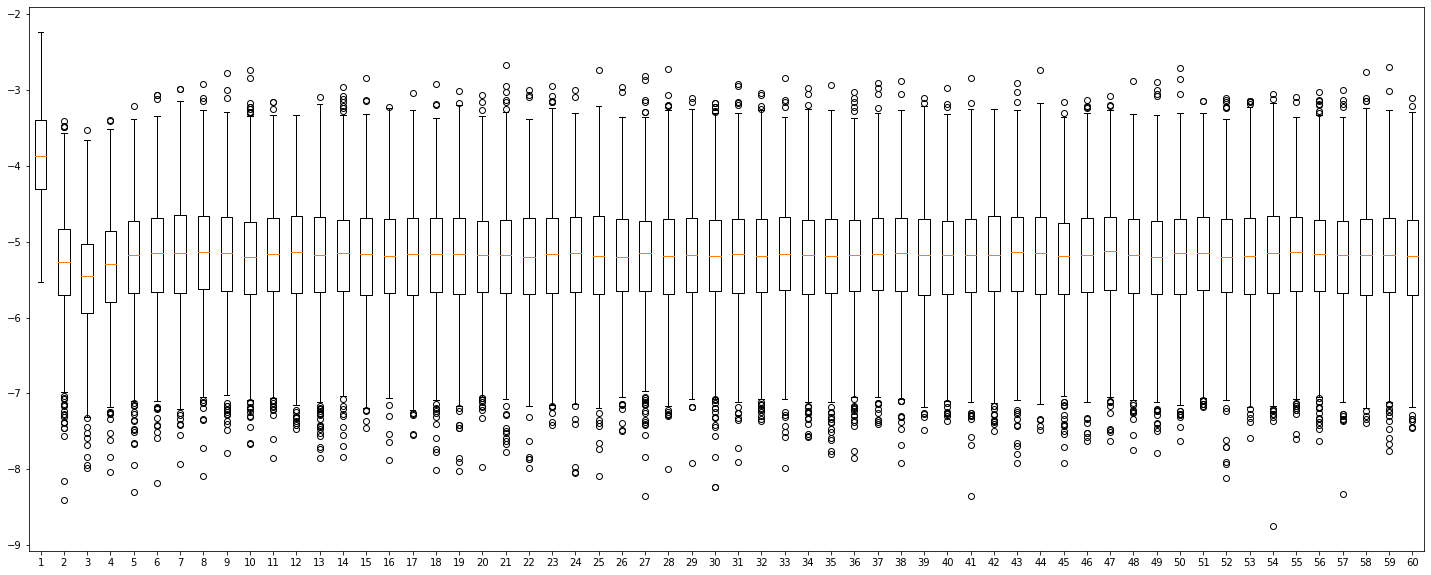

Which seems to imply a positive prediction incurred when the times are the same. Even more interesting is the slight dip after the 1st minute, which then seems to pop back up in the first few nearby minutes!

Verify below that your model produces something similar:

In [ ]:
# A15:SanityCheck

# GPU flag!
g = True

plt.figure(figsize=(25, 10))

d = 256
hidden_dim = 128
pos_weight = 5
batch_size = 32

enhanced = torch.load(f'./data/False_{d}_{hidden_dim}_{pos_weight}_{batch_size}.pt')

delta_scores = [[] for _ in range(60)]
for s in range(1440):
    if s % 100 == 0:
        print('Start index:', s)

    scores = probe_time(enhanced, s, gpu=g)
    for ix, s in enumerate(scores):
        delta_scores[ix].append(s)

box_plot_data = [delta_scores[d] for d in range(60)]

plt.boxplot(box_plot_data)

plt.show()

### Reflecting on our Results

If you're here, you've made it through the assignment! Congrats and good work! We've really pushed into some model complexity that (hopefully) has begun to hone your comfort with building out neural architectures. 

It's worth remarking on a question though: How'd we do on this task? How'd we do relative to what's previously been done? 

Well, the authors of the original paper report the following (using a feed-forward network): 
```
P: 0.737 
R: 0.710 
F1: 0.723
```

This is a lot higher than what we've seen here, but there's a catch: The authors have done three critical things:
* Used a variety of additional non-NLP features (which includes other structural, temporal, and past context-based features)
* Heavily optimized and investigated good hyperparameters for their network
* Use a scroll-back of the past 101 posts (as opposed to the past 20)

Reviewing some of the features that the authors used, they feed their network:
* Token overlap percentages between considered pairs of messages
* An average of pre-trained GloVe vectors (which have been trained **much longer** and on a **far larger** corpus)
* Information about directedness 
* Information about time 
* A past message history 

just to name a few features that seem particularly interesting. 
If you'd like to see what they've done and look at the architecture and features they've used, see their [GitHub repository](https://github.com/jkkummerfeld/irc-disentanglement/tree/master/src).
In many ways, their approach is one where they give a model a set of hand-crafted, structured features which their model interprets. 
Our network is one that takes raw text-based features and attempts to learn an interpretation of them that is useful for conversational disentanglement.

The take-away here should be this: There is a lot we could do to make a better model. We could train for longer. We could pre-train GloVe vectors for longer and on more data. And there are so many other non-NLP features that we could also have our model ingest and interpret, some that are non-linguistic yet highly salient for this difficult, social NLP task.
That's before even considering all the hyperparameter tuning we could explore (learning rates, hidden dimensions, weight decay, layers, etc.).

We also have far more data we could feed to our model, we could give a collection of past posts and we could try to use user information (maybe certain users only reply to other users and users don't reply to themselves?). 
And that doesn't even consider how we could re-sample our data by selecting different mechanisms for generating "negative" connections.

There's a lot to be attempted beyond this and there are even-better architectures to be explored! 
Yet, hopefully, you feel as though you've taken a good, hard look at what can be achieved if we reduce our features to just the basic, raw lingustic ones and explore very simplistic neural architectures. 
Hopefully this makes you curious about what more could be done 
and how we could adjust what we've built here into something even more powerful and competitive.

If you come up with a better model for this task, perhaps you could publish it!
This is an open and hot research task, so novelty and breakthroughs are very interesting to the NLP-research community.